In [19]:
import os
import numpy as np
import nibabel as nib
from nilearn.masking import apply_mask, unmask
from nilearn.maskers import NiftiMasker
from nilearn import image
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy

def load_mask(subject):
    mask_path = (
        f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/'
        f'slabpreproc/sub-{subject}/ses-1/atlas/'
        f'tpl-{subject}_res-02_desc-brain_mask.nii.gz'
    )
    mask_img = nib.load(mask_path)
    return mask_img


def mean_pairwise_correlations(time_series):
    n_sessions = len(time_series)
    n_voxels = time_series[0].shape[1]
    n_pairs = n_sessions * (n_sessions - 1) // 2

    # Compute pairwise correlations for each voxel
    pairwise_correlations = np.zeros((n_voxels, n_pairs))
    for voxel in range(n_voxels):
        pair_idx = 0
        for session1, session2 in itertools.combinations(range(n_sessions), 2):
            correlation, _ = pearsonr(time_series[session1][:, voxel], time_series[session2][:, voxel])
            pairwise_correlations[voxel, pair_idx] = correlation
            pair_idx += 1

    # Calculate the noise ceiling for each voxel
    mpc = np.mean(pairwise_correlations, axis=1)

    return mpc

def explainable_variance(data, bias_correction=True, do_zscore=True):
    """Compute explainable variance for a set of voxels."""
    # correction is for low sample size
    if do_zscore:
        data = scipy.stats.zscore(data, axis=1)

    mean_var = data.var(axis=1, dtype=np.float64, ddof=1).mean(axis=0)
    var_mean = data.mean(axis=0).var(axis=0, dtype=np.float64, ddof=1)
    ev = var_mean / mean_var

    if bias_correction:
        n_repeats = data.shape[0]
        ev = ev - (1 - ev) / (n_repeats - 1)
    return ev

def calculate_tsfnr(time_series_array):
    """Calculate temporal signal-to-fluctuation ratio for a set of voxels."""
    mean_signal = np.mean(time_series_array, axis=1)
    std_signal = np.std(time_series_array, axis=1)
    tsfnr = mean_signal / std_signal
    return tsfnr

def threshold_mask(mask_img, threshold=0.5):
    return image.math_img(f"img > {threshold}", img=mask_img)

subjects = ['Damy001', 'Damy002', 'Damy003']
sessions = ['1', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8']

all_mpcs = []
all_explainable_variances = []
all_tsfnrs = []



In [20]:
for subject in subjects:
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]

    # Extract time series for each session
    time_series = []
    mask_nii = load_mask(subject)  # Moved outside the loop
    thresholded_mask_nii = threshold_mask(mask_nii)  # Threshold the probabilistic mask
    for data in tqdm(fmri_data, desc=f"Extracting time series for {subject}"):
        masker = NiftiMasker(mask_img=thresholded_mask_nii)
        masker.fit(data)
        time_series.append(masker.transform(data))

    mpc = mean_pairwise_correlations(time_series)
    all_mpcs.append(mpc)

    time_series_array = np.stack(time_series, axis=0)
    ev = explainable_variance(time_series_array)
    all_explainable_variances.append(ev)

    tsfnr = calculate_tsfnr(time_series_array)
    all_tsfnrs.append(tsfnr)


Extracting time series for Damy001: 100%|██████████| 12/12 [08:49<00:00, 44.15s/it]
/home/zdiamand/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/central/software/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
Extracting time series for Damy003: 100%|██████████| 12/12 [09:41<00:00, 48.42s/it]


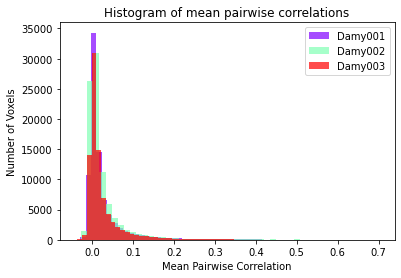

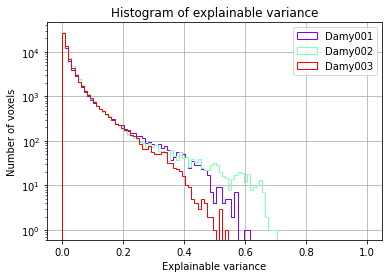

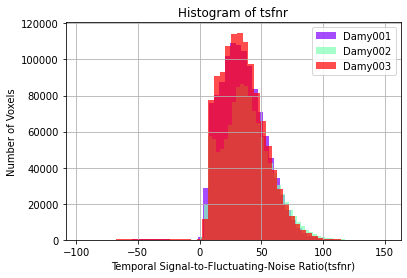

In [23]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, mpc, color in zip(subjects, all_mpcs, colors):
    plt.hist(mpc, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Mean Pairwise Correlation')
plt.ylabel('Number of Voxels')
plt.title('Histogram of mean pairwise correlations')
plt.legend()
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, ev, color in zip(subjects, all_explainable_variances, colors):
    ev_no_na = ev[np.isfinite(ev)]
    plt.hist(ev_no_na, bins=np.linspace(0, 1, 100), log=True, histtype='step', color=color, label=subject)
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.legend()
plt.grid('on')
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, tsfnr, color in zip(subjects, all_tsfnrs, colors):
    tsfnr_no_na = tsfnr[np.isfinite(tsfnr)]
    plt.hist(tsfnr_no_na, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Temporal Signal-to-Fluctuating-Noise Ratio(tsfnr)')
plt.ylabel('Number of Voxels')
plt.title('Histogram of tsfnr')
plt.legend()
plt.grid('on')
plt.show()


/home/zdiamand/.local/lib/python3.7/site-packages/nilearn/_utils/niimg.py:64: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


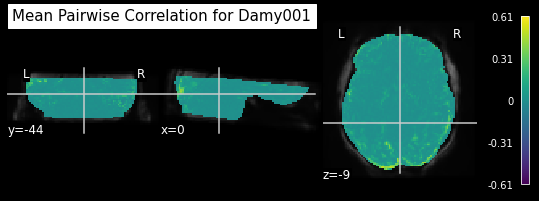

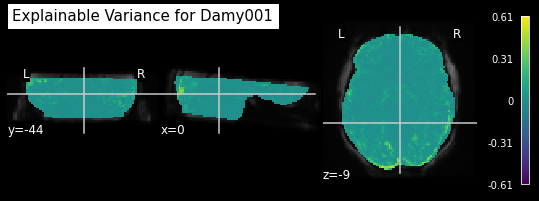

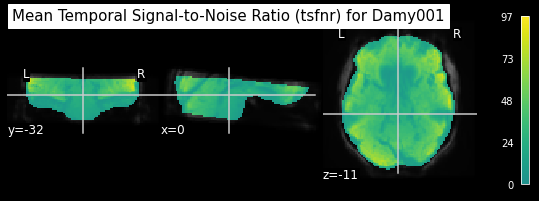

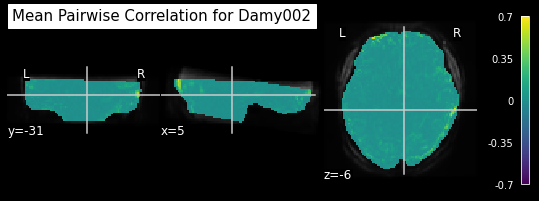

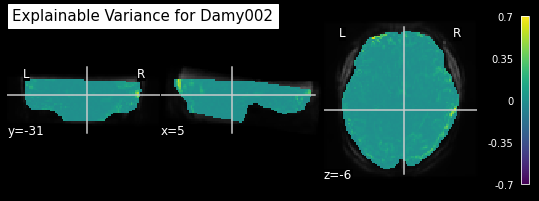

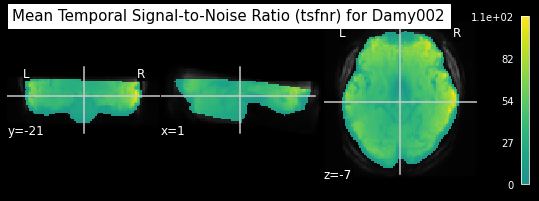

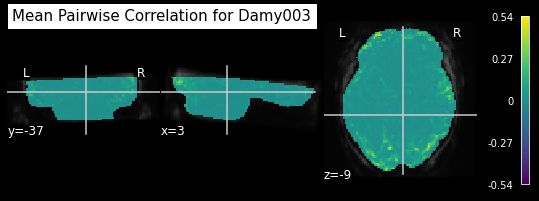

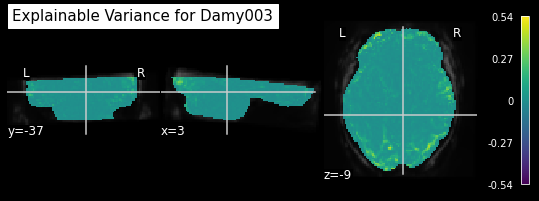

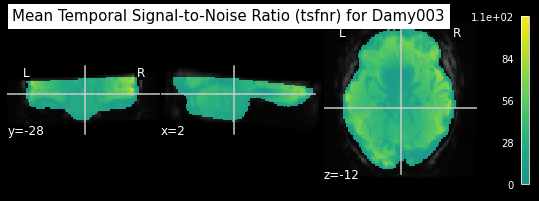

In [25]:
# Create a function to compute the mean EPI image from a list of fmri_data
def compute_mean_epi_img(fmri_data):
    return image.mean_img(fmri_data)

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))

for subject, mpc, ev, tsfnr, color in zip(subjects, all_mpcs, all_explainable_variances, all_tsfnrs, colors):
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]
    mean_epi_img = compute_mean_epi_img(fmri_data)
    
    thresholded_mask_nii = threshold_mask(load_mask(subject))
    masker = NiftiMasker(mask_img=thresholded_mask_nii)
    masker.fit(mean_epi_img)
    
    # Convert the noise ceiling values back to a brain volume
    mpc_img = masker.inverse_transform(mpc)

    # Visualize the spatial distribution of noise ceiling values
    mpc_plot = plotting.plot_stat_map(mpc_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Pairwise Correlation for {subject}', cmap='viridis')
    plt.show()

    # Convert the explainable variance values back to a brain volume
    ev_img = masker.inverse_transform(ev)

    # Visualize the spatial distribution
    ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title=f'Explainable Variance for {subject}', cmap='viridis')
    plt.show()

    # Calculate the mean tsfnr across sessions
    mean_tsfnr = np.mean(tsfnr, axis=0)  

    # Convert the mean tsfnr values back to a brain volume
    mean_tsfnr_img = masker.inverse_transform(mean_tsfnr)

    # Visualize the spatial distribution
    mean_tsfnr_plot = plotting.plot_stat_map(mean_tsfnr_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Temporal Signal-to-Noise Ratio (tsfnr) for {subject}', cmap='viridis')
    plt.show()


# Amygdala

In [34]:
def load_amygdala_mask(subject):
    atlas_file = f'/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-1/atlas/tpl-{subject}_res-02_atlas-cit168_desc-subcort_dseg.nii.gz'
    atlas_data = nib.load(atlas_file).get_fdata()
    amygdala_labels = [17, 18, 19]

    # Create a mask that includes voxels with any of the amygdala label values
    amygdala_mask = np.zeros_like(atlas_data)
    for label in amygdala_labels:
        amygdala_mask[atlas_data == label] = 1

    return nib.Nifti1Image(amygdala_mask, nib.load(atlas_file).affine)



In [35]:
all_mpcs = []
all_explainable_variances = []
all_tsfnrs = []

for subject in subjects:
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]

    # Extract time series for each session
    time_series = []
    mask_nii = load_amygdala_mask(subject)  # Moved outside the loop
    thresholded_mask_nii = threshold_mask(mask_nii)  # Threshold the probabilistic mask
    for data in tqdm(fmri_data, desc=f"Extracting time series for {subject}"):
        masker = NiftiMasker(mask_img=thresholded_mask_nii)
        masker.fit(data)
        time_series.append(masker.transform(data))

    mpc = mean_pairwise_correlations(time_series)
    all_mpcs.append(mpc)

    time_series_array = np.stack(time_series, axis=0)
    ev = explainable_variance(time_series_array)
    all_explainable_variances.append(ev)

    tsfnr = calculate_tsfnr(time_series_array)
    all_tsfnrs.append(tsfnr)


Extracting time series for Damy003: 100%|██████████| 12/12 [08:01<00:00, 40.16s/it]


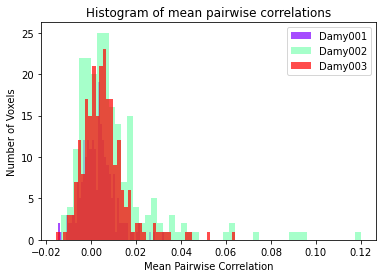

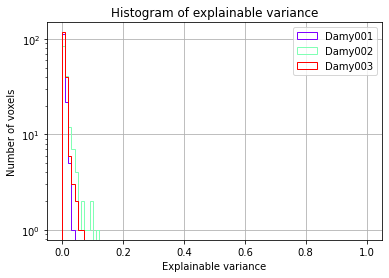

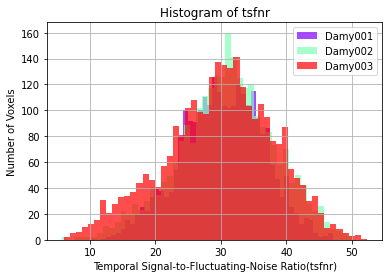

In [36]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, mpc, color in zip(subjects, all_mpcs, colors):
    plt.hist(mpc, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Mean Pairwise Correlation')
plt.ylabel('Number of Voxels')
plt.title('Histogram of mean pairwise correlations')
plt.legend()
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, ev, color in zip(subjects, all_explainable_variances, colors):
    ev_no_na = ev[np.isfinite(ev)]
    plt.hist(ev_no_na, bins=np.linspace(0, 1, 100), log=True, histtype='step', color=color, label=subject)
plt.xlabel("Explainable variance")
plt.ylabel("Number of voxels")
plt.title('Histogram of explainable variance')
plt.legend()
plt.grid('on')
plt.show()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))
plt.figure()
for subject, tsfnr, color in zip(subjects, all_tsfnrs, colors):
    tsfnr_no_na = tsfnr[np.isfinite(tsfnr)]
    plt.hist(tsfnr_no_na, bins=50, color=color, alpha=0.7, label=subject)
plt.xlabel('Temporal Signal-to-Fluctuating-Noise Ratio(tsfnr)')
plt.ylabel('Number of Voxels')
plt.title('Histogram of tsfnr')
plt.legend()
plt.grid('on')
plt.show()


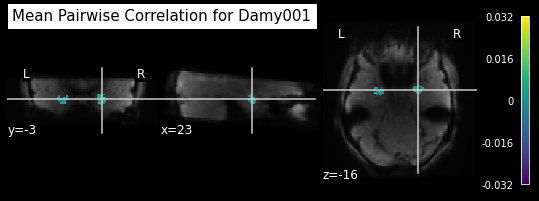

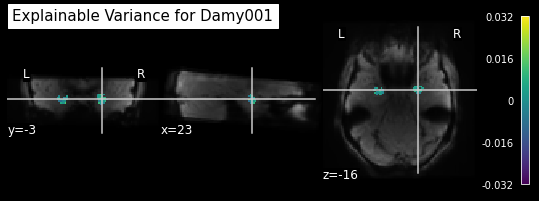

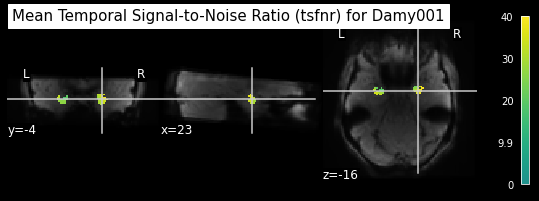

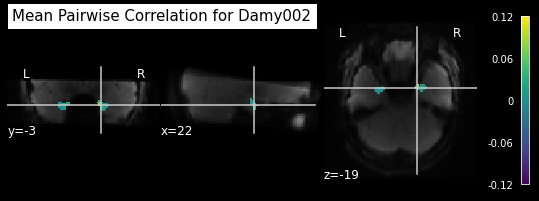

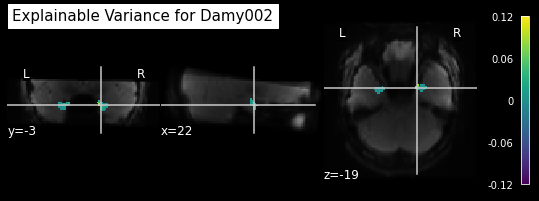

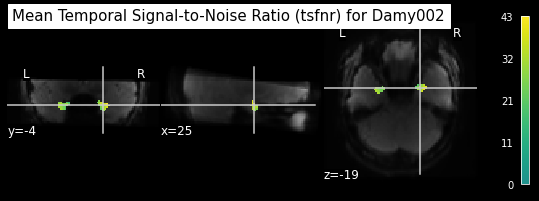

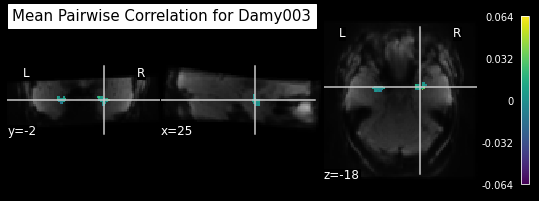

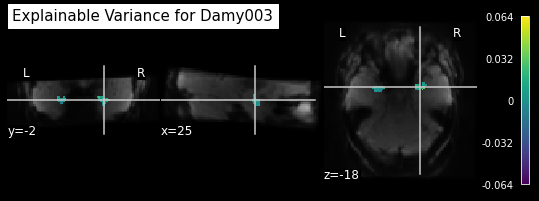

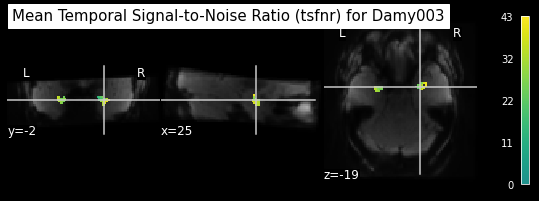

In [39]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(subjects))))

for subject, mpc, ev, tsfnr, color in zip(subjects, all_mpcs, all_explainable_variances, all_tsfnrs, colors):
    fmri_data = [nib.load(f"/central/groups/adolphslab/DenseAmygdala/Routine/derivatives/slabpreproc/sub-{subject}/ses-{session}/preproc/sub-{subject}_ses-{session}_task-trailer_part-mag_recon-preproc_bold.nii.gz") for session in sessions]
    mean_epi_img = compute_mean_epi_img(fmri_data)
    
    thresholded_mask_nii = threshold_mask(load_amygdala_mask(subject))
    masker = NiftiMasker(mask_img=thresholded_mask_nii)
    masker.fit(mean_epi_img)
    
    # Convert the noise ceiling values back to a brain volume
    mpc_img = masker.inverse_transform(mpc)

    # Visualize the spatial distribution of noise ceiling values
    mpc_plot = plotting.plot_stat_map(mpc_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Pairwise Correlation for {subject}', cmap='viridis')
    plt.show()

    # Convert the explainable variance values back to a brain volume
    ev_img = masker.inverse_transform(ev)

    # Visualize the spatial distribution
    ev_plot = plotting.plot_stat_map(ev_img, bg_img=mean_epi_img, threshold=0, title=f'Explainable Variance for {subject}', cmap='viridis')
    plt.show()

    # Calculate the mean tsfnr across sessions
    mean_tsfnr = np.mean(tsfnr, axis=0)  

    # Convert the mean tsfnr values back to a brain volume
    mean_tsfnr_img = masker.inverse_transform(mean_tsfnr)

    # Visualize the spatial distribution
    mean_tsfnr_plot = plotting.plot_stat_map(mean_tsfnr_img, bg_img=mean_epi_img, threshold=0, title=f'Mean Temporal Signal-to-Noise Ratio (tsfnr) for {subject}', cmap='viridis')
    plt.show()
